In [5]:
from skimage import data

In [6]:
from skimage.color import rgb2gray
from numpy import r_

In [7]:
from io import BytesIO

In [8]:
from matplotlib import pyplot as plt

In [9]:
%matplotlib inline

In [10]:
DEFAULT_IMG_SIZE = (256, 256)

In [11]:
from skimage.transform import resize
import io
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import IPython
import pandas as pd

from IPython.display import display, HTML

### Compression performance measures functions

In [12]:
def calculate_mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    return err

def calculate_psnr(imageA, imageB):
    mse = np.mean( (imageA - imageB) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    
    return 10 * np.log10(PIXEL_MAX / np.sqrt(mse))


def print_measures(imageA, imageB):
    display(HTML('<h1> Measures </h1>'))
    
    display(HTML(pd.DataFrame([[calculate_mse(imageA, imageB),
                       calculate_psnr(imageA, imageB)]],
                       columns=["MSE", "PSNR"]).to_html()))

### Load images

In [13]:
def get_image_and_resize(img_arr, size=DEFAULT_IMG_SIZE):
    image = Image.fromarray(img_arr)
    img_color = image.resize(size, 1)
    img_grey = img_color.convert('L')
    img = np.array(img_grey, dtype=np.float)

    return img

In [165]:
from skimage import img_as_ubyte, img_as_float

gray_images = {
    "cat": get_image_and_resize(data.chelsea()),
    "rocket": get_image_and_resize(data.rocket()),
    "moon": get_image_and_resize(data.moon()),
    "camera": get_image_and_resize(data.camera()),
    "coin": get_image_and_resize(data.coins()),
}

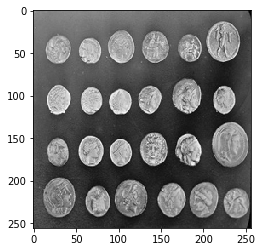

In [15]:
plt.imshow(gray_images['coin'], cmap=plt.cm.gray)

In [16]:
from numpy.linalg import svd
import numpy as np

# SVD

In [17]:
def compress_svd(img, k):
    """
    K - singular values
    """
    U, s, V = svd(img, full_matrices=False)
    reconst_matrix = np.dot(U[:, :k], np.dot(np.diag(s[:k]), (V[:k, :])))
    
    return reconst_matrix, s

In [18]:
print(gray_images['cat'].shape)

(256, 256)


### Compress image and show result

In [224]:
def compress_svd_show(img_name, k, show_gray_image=True,
                      should_print_measures=True):
    """
    """
    image = gray_images[img_name]
    original_shape = image.shape
    
    reconst_img, s = compress_svd(image, k)
    
    compression_ratio = (original_shape[0] * original_shape[1]) / (
        k * (original_shape[0] + original_shape[1]) + k) 
        
    print("Compression ratio: {}".format(compression_ratio))
    if show_gray_image:
        fig, axes = plt.subplots(1, 2, figsize=(8, 5))
        axes[0].plot(s)
        
        axes[1].set_title("compression ratio {:.2f} %".format(compression_ratio))
        axes[1].imshow(reconst_img, cmap='gray')
        axes[1].axis('off')

        fig.tight_layout()
        
    if should_print_measures:
        print_measures(image, reconst_img)
    
    return reconst_img

In [173]:
from ipywidgets import interact, interactive, widgets

In [174]:
interact(compress_svd_show, img_name=list(gray_images.keys()), k=(1, DEFAULT_IMG_SIZE[0]))

interactive(children=(Dropdown(description='img_name', options=('cat', 'rocket', 'moon', 'camera', 'coin'), va…

<function __main__.compress_svd_show(img_name, k, show_gray_image=True, should_print_measures=True)>

# DCT

In [175]:
def get_2d_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img, norm='ortho', axis=0), norm='ortho', axis=1)

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients, axis=0 , norm='ortho'), axis=1 , norm='ortho')

### Blockwize dct / inverse dct function

In [176]:
def compress_dct(img):
    
    imsize = DEFAULT_IMG_SIZE
    dct = np.zeros(imsize)

    for i in r_[:imsize[0]:8]:
        for j in r_[:imsize[1]:8]:
            dct[i:(i+8),j:(j+8)] = get_2d_dct(img[i:(i+8),j:(j+8)] )
            
    return dct

In [177]:
def decompress_dct(img):
    
    imsize = DEFAULT_IMG_SIZE
    dct = np.zeros(imsize)

    for i in r_[:imsize[0]:8]:
        for j in r_[:imsize[1]:8]:
            dct[i:(i+8),j:(j+8)] = get_2d_idct(img[i:(i+8),j:(j+8)] )
            
    return dct

### Filter function after applying DCT

In [178]:
def filter_by_number(dct, k):
    imsize = DEFAULT_IMG_SIZE
    dct_thresh = np.zeros(imsize)
    
    # Do 8x8 DCT on image (in-place)
    for i in r_[:imsize[0]:8]:
        for j in r_[:imsize[1]:8]:
            dummy_matrix = dct[i:(i+8),j:(j+8)]
            
            dummy_matrix[k:,:] = 0
            dummy_matrix[:,k:] = 0
            
            dct_thresh[i:(i+8),j:(j+8)] = dummy_matrix
    
    return dct_thresh

def filter_by_threshold(dct, thresh = 0.0012):
    imsize = DEFAULT_IMG_SIZE

    dct_thresh = dct * (abs(dct) > (thresh * np.max(dct)))

    nonzeros_count = np.sum( dct_thresh != 0.0 )
    
    compression_ratio = (original_shape[0] * original_shape[1]) / nonzeros_count
        
    percent_nonzeros =  nonzeros_count / (imsize[0] * imsize[1]*1.0)

    print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
    print("Compression ratio: {}".format(compression_ratio))
    
    return dct_thresh

### Compress image and show result

In [179]:
def compress_dct_show(img_name, k, show_gray_image=True, should_print_measures=True):
    image = gray_images[img_name]
    dct_size = image.shape[0]
    dct = get_2d_dct(image)
    
    dct_copy = dct.copy()
    dct_copy[k:,:] = 0
    dct_copy[:,k:] = 0
    
    nonzeros_count = np.sum( dct_copy != 0.0 )
    compression_ratio = (image.shape[0] * image.shape[1]) / nonzeros_count
    print("Compression ratio: {}".format(compression_ratio))
    
    # Reconstructed image
    reconst_img = get_2d_idct(dct_copy)
    
    if show_gray_image:
        plt.figure()
        plt.imshow(reconst_img ,cmap='gray')
        plt.title("Reconstructed image" )
        
    if should_print_measures:
        print_measures(image, reconst_img)
    
    return reconst_img

Text(0.5, 1.0, '8x8 DCTs of the image')

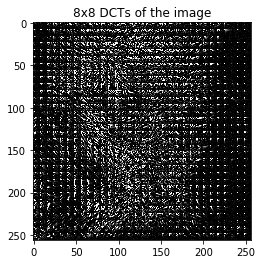

In [180]:
dct = compress_dct(gray_images['cat'])
plt.figure()
plt.imshow(dct, cmap='gray', vmax = np.max(dct) * 0.01, vmin = 0)
plt.title( "8x8 DCTs of the image")

Compression ratio: 163.84


array([[127.47051227, 127.37663836, 127.20218255, ...,  39.76697841,
         40.44399587,  40.788954  ],
       [128.02807985, 127.93196429, 127.7528038 , ...,  40.11264659,
         40.77004437,  41.10496104],
       [129.1268294 , 129.0263521 , 128.8380293 , ...,  40.79547921,
         41.41447507,  41.72973769],
       ...,
       [ 80.33704818,  80.74981318,  81.56926361, ..., 148.2261543 ,
        146.37591784, 145.42371153],
       [ 80.0060188 ,  80.42202835,  81.24798354, ..., 148.01280867,
        146.08698613, 145.09595018],
       [ 79.83881521,  80.25643171,  81.08561063, ..., 147.90338249,
        145.9389384 , 144.9280626 ]])

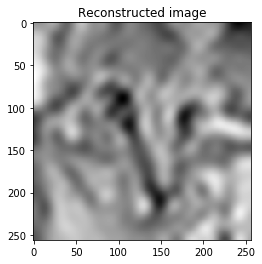

In [181]:
# compress_dct_show('cat', 0.0012, should_print_measures=False)
compress_dct_show('cat', 20, should_print_measures=False)

In [182]:
# interact(compress_dct_show, img_name=list(gray_images.keys()),
#          thresh=widgets.FloatSlider(min=0.0, max=0.1, step=0.001))
interact(compress_dct_show, img_name=list(gray_images.keys()),
         k=(0, 256))

interactive(children=(Dropdown(description='img_name', options=('cat', 'rocket', 'moon', 'camera', 'coin'), va…

<function __main__.compress_dct_show(img_name, k, show_gray_image=True, should_print_measures=True)>

Compression ratio: 1.0


,MSE,PSNR
0,1.851886e-28,162.727331


array([[125., 123., 123., ...,  33.,  31.,  30.],
       [129., 125., 124., ...,  33.,  32.,  33.],
       [131., 128., 127., ...,  33.,  33.,  35.],
       ...,
       [ 57.,  88.,  95., ..., 154., 153., 153.],
       [ 97., 104.,  83., ..., 148., 149., 149.],
       [106.,  92.,  87., ..., 142., 143., 144.]])

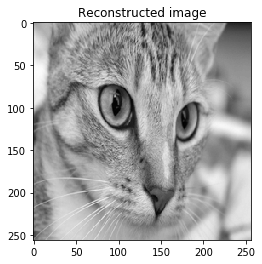

In [183]:
compress_dct_show('cat', 256)

## Wavelet

In [184]:
import pywt

In [185]:
def compress_dwt(image, wavelet='haar'):
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
    
#     fig = plt.figure()
#     for i, a in enumerate([LL, LH, HL, HH]):
#         ax = fig.add_subplot(2, 2, i + 1)
#         ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
#         ax.set_title(titles[i], fontsize=12)
#         ax.set_xticks([])
#         ax.set_yticks([])
    
    # Now reconstruct and plot the original image
    reconstructed = pywt.idwt2(coeffs2, wavelet=wavelet)
    
    
    return coeffs2

def compress_dwt_show(img_name, k, wavelet='haar', show_gray_image=True, should_print_measures=True):
    img = gray_images[img_name]
    old_img = img
    
    for iteration in range(k):
        img, _ = compress_dwt(img, wavelet)
        
    if show_gray_image:    
        fig = plt.figure()
        plt.imshow(img, interpolation="nearest", cmap=plt.cm.gray)
    
    if should_print_measures:
        print_measures(old_img, np.resize(img, DEFAULT_IMG_SIZE))

In [186]:
interact(compress_dwt_show, img_name=list(gray_images.keys()), k=(0, 2), wavelet=pywt.wavelist())

interactive(children=(Dropdown(description='img_name', options=('cat', 'rocket', 'moon', 'camera', 'coin'), va…

<function __main__.compress_dwt_show(img_name, k, wavelet='haar', show_gray_image=True, should_print_measures=True)>

In [187]:
def tell_img_size(array):
    image = Image.fromarray(array)
    image = image.convert("L")
    img_file = BytesIO()
    image.save(img_file, 'png')
    print(img_file.tell())

## Compare SVD and DCT

Compression ratio: 2.9127111111111113


,MSE,PSNR
0,60.2913,15.164129


CPU times: user 22.8 ms, sys: 3.08 ms, total: 25.9 ms
Wall time: 22.7 ms


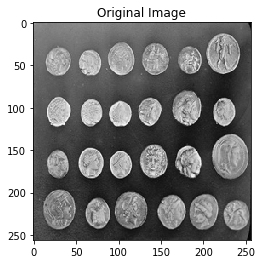

In [213]:
%%time
k = 150
compress_dct_show('coin', k, show_gray_image=False)
fig = plt.figure()
plt.imshow(gray_images['coin'], cmap=plt.cm.gray)
plt.title('Original Image')

Compression ratio: 2.555009746588694


,MSE,PSNR
0,61.187808,15.132077


CPU times: user 197 ms, sys: 6.05 ms, total: 203 ms
Wall time: 104 ms


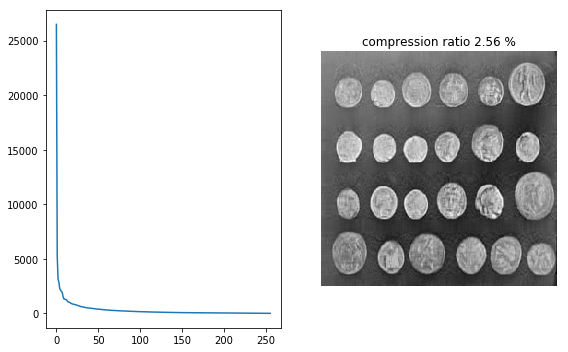

In [225]:
%%time
k = 50
compress_svd_show('coin', k)

### results for paper

In [196]:
k_s = [1, 5, 30, 60, 120, 160]
images = []
for k in k_s: 
    images.append(compress_dct_show('rocket', k,
                                show_gray_image=False,
                                ))


Compression ratio: 65536.0


,MSE,PSNR
0,878.11109,9.347654


Compression ratio: 2621.44


,MSE,PSNR
0,375.033263,11.195053


Compression ratio: 72.81777777777778


,MSE,PSNR
0,134.87104,13.415808


Compression ratio: 18.204444444444444


,MSE,PSNR
0,67.712194,14.912067


Compression ratio: 4.551111111111111


,MSE,PSNR
0,34.127616,16.399872


Compression ratio: 2.56


,MSE,PSNR
0,20.965188,17.457908


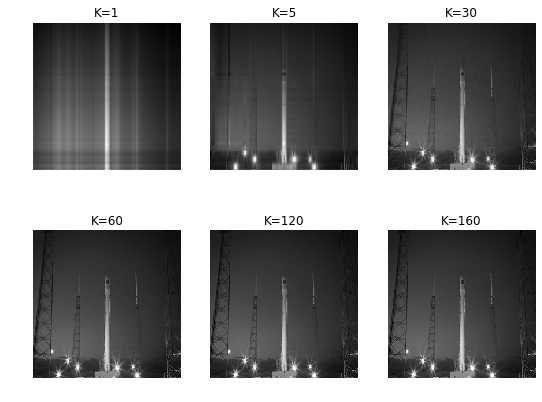

In [192]:

f, ax_arr = plt.subplots(2, 3, sharey=True, figsize=(9, 7))

for index, k in enumerate(k_s):
    ax_arr[index // 3, index - 3 * (index // 3)].imshow(images[index], cmap='gray')
    ax_arr[index // 3, index - 3 * (index // 3)].axis('off')
    ax_arr[index // 3, index - 3 * (index // 3)].set_title('K={}'.format(k))